In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
train_df = pd.read_parquet('train.parquet')

In [4]:
train_df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


# EDA

In [5]:
train_df['label'].unique()

array([0., 1.])

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


Пока пропусков нет в данных.   

Необходимо проверить пропуски в списках дат и значений для каждого временного ряда

In [7]:
# Сопоставление дат и значений
df = train_df.explode(['dates', 'values']).reset_index(drop=True)
df

,id,dates,values,label
0,19114,2016-01-01,-1.86,0.0
1,19114,2016-02-01,0.79,0.0
2,19114,2016-03-01,1.4,0.0
3,19114,2016-04-01,0.15,0.0
4,19114,2016-05-01,0.0,0.0
...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0
5155408,98870,2019-12-01,0.26335,1.0
5155409,98870,2020-01-01,-1.73665,1.0
5155410,98870,2020-02-01,-0.38665,1.0


In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5155412 entries, 0 to 5155411
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      5155412 non-null  int64  
 1   dates   5155412 non-null  object 
 2   values  5150830 non-null  object 
 3   label   5155412 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 157.3+ MB


У некоторых объектов отстутсвуют значения

In [9]:
# Список временных рядов с пропущенными значениями
list_na = df[df['values'].isna()]['id'].unique()
list_na

array([95215, 56091, 63162, 29359, 12983, 10106, 35563, 26443, 76005,
       69579, 96443, 54828, 56573, 19771, 30500, 25222, 67777, 51212,
       27996, 99921, 82650, 48824, 31846, 73636, 13621, 10597, 84109,
       53775, 14063, 26492, 93061, 49533, 23286, 64147,  8605, 51767,
       31267, 29818, 84062, 50050, 35480, 38094,  3062, 67793, 43337,
       71485, 59394, 50626,  7812, 20576, 19733,  3801, 78629, 83952,
        4584, 69473, 27213, 65984,  3018, 20388, 95328, 66726, 38786,
       28497, 67010, 93633,  7678, 98979, 17051, 21269, 29772, 88009,
       44365, 61474, 79933, 21720, 58427, 13753, 82991, 75584,  7209,
       30924, 84860, 61409, 28644, 31408, 67417, 72302])

In [10]:
len(list_na)

88

In [11]:
train_df[train_df['id'] == 95215]

,id,dates,values,label
1979,95215,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0


Найдём ряды, в которых пропущены более 90% значений

In [12]:
# Пороговое значение (90%)
threshold = 0.9

# Функция для вычисления доли пропущенных значений
def check_missing_values(row, threshold = 1):
    total_values = len(row['values'])
    missing_values = sum(pd.isna(row['values']))

    if (missing_values / total_values) >= threshold:
        return row['id']
    else:
        return None

missing_ids = train_df.apply(check_missing_values, threshold = threshold, axis=1)

# Фильтрация id, где более 90% значений NaN
missing_ids = missing_ids.dropna().tolist()

print(f"Количество рядов в которых пропущено {threshold*100}% значений: {len(missing_ids)}")

Количество рядов в которых пропущено 90.0% значений': 88


Количество рядов, у которых есть хотя бы одно NA значение совпадает с количеством рядов, у которых все значения NA.   Значит можно удалить эти ряды

In [13]:
# Удаление строк, id которых содержатся в missing_ids
df = df[~df['id'].isin(missing_ids)].reset_index(drop=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150830 entries, 0 to 5150829
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   dates   object 
 2   values  object 
 3   label   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 157.2+ MB


In [15]:
list_na_dates = df[df['dates'].isna()]['id'].unique()
list_na_dates

array([], dtype=int64)

У дат нет пропущенных значений

Восстановим для каждого ряда интервал дат и присовим им значение na, в случае пропуска какой-либо даты

In [16]:
def restore_missing_dates(df, date_col='dates', id_col='id', freq='MS'):
    """
    Восстанавливает пропущенные даты для каждого id и добавляет строки с NaN значениями в столбце values, если даты отсутствуют.
    :param df: DataFrame, содержащий столбцы с датами и id.
    :param date_col: Название столбца с датами.
    :param id_col: Название столбца с идентификаторами (id).
    :param freq: Частота для генерации диапазона дат (по умолчанию 'MS' - начало месяца).
    :return: Новый DataFrame с восстановленными датами и добавленными NaN значениями.
    """

    # Преобразование в формат datetime
    df[date_col] = pd.to_datetime(df[date_col])

    # Минимальные и максимальные даты для каждого 'id'
    date_ranges = df.groupby(id_col)[date_col].agg(['min', 'max'])

    # Функция для генерации полного диапазона дат
    def generate_full_dates(row):
        return pd.date_range(start=row['min'], end=row['max'], freq=freq)

    # Для каждого id создаётся полный список дат
    full_dates = date_ranges.apply(generate_full_dates, axis=1)

    # Превращение этого списка в DataFrame
    full_dates_df = full_dates.explode().reset_index().rename(columns={0: date_col})

    # Объединение оригинального и нового датафреймов
    df_full = pd.merge(full_dates_df, df, on=[id_col, date_col], how='left')

    return df_full

df_restored = restore_missing_dates(df)

In [17]:
df_restored.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150830 entries, 0 to 5150829
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   id      5150830 non-null  int64         
 1   dates   5150830 non-null  datetime64[ns]
 2   values  5150830 non-null  object        
 3   label   5150830 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 157.2+ MB


Интервал дат для каждого временного ряда не имеет пропусков

In [18]:
sum(df['label'] == 0) / sum(df['label'] == 1)

2.655502738701349

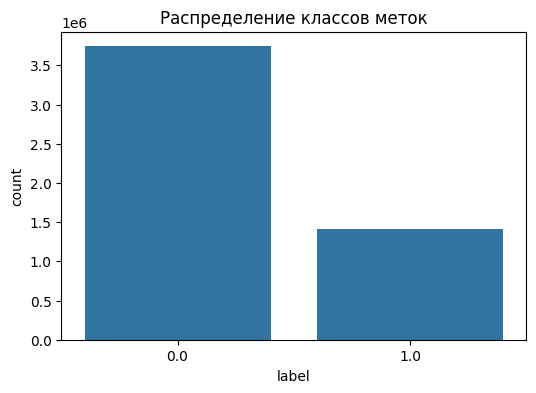

In [19]:
# Распределение классов меток
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Распределение классов меток')
plt.show()

Метки с классом 0 почти в 3 раза превышают метки с классом 1, что указывает на явный дисбаланс в распределении меток. Нужно использовать class_weight в линейных моделях или ансамблевые модели

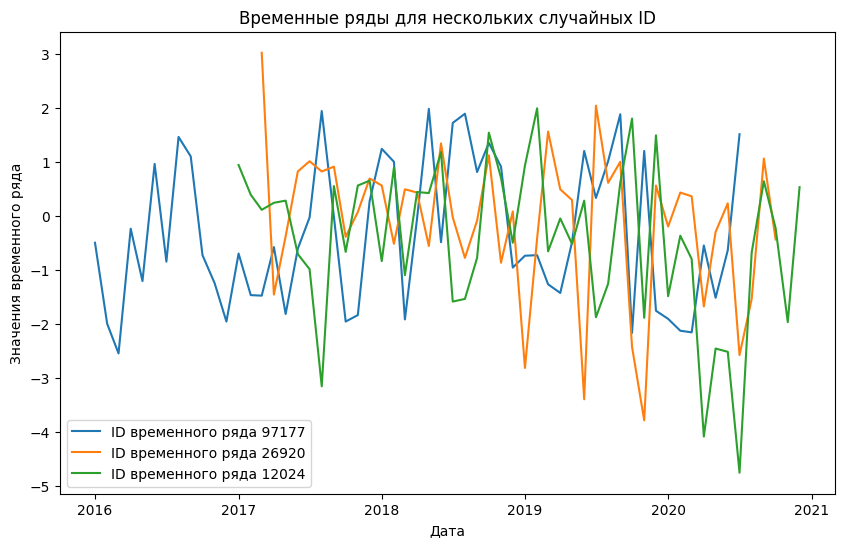

In [20]:
# Случайный выбор нескольких ID
sample_ids = df['id'].sample(3).unique()
plt.figure(figsize=(10, 6))

for sample_id in sample_ids:

    sample_data = df[df['id'] == sample_id]
    plt.plot(sample_data['dates'], sample_data['values'], label=f'ID временного ряда {sample_id}')


plt.title('Временные ряды для нескольких случайных ID')
plt.xlabel('Дата')
plt.ylabel('Значения временного ряда')
plt.legend()
plt.show()

Большинство временных рядов имеют разные промежутки дат, но так как решается задача классификации, а не регрессии, восстанавливать весь диапазон нет необходимости

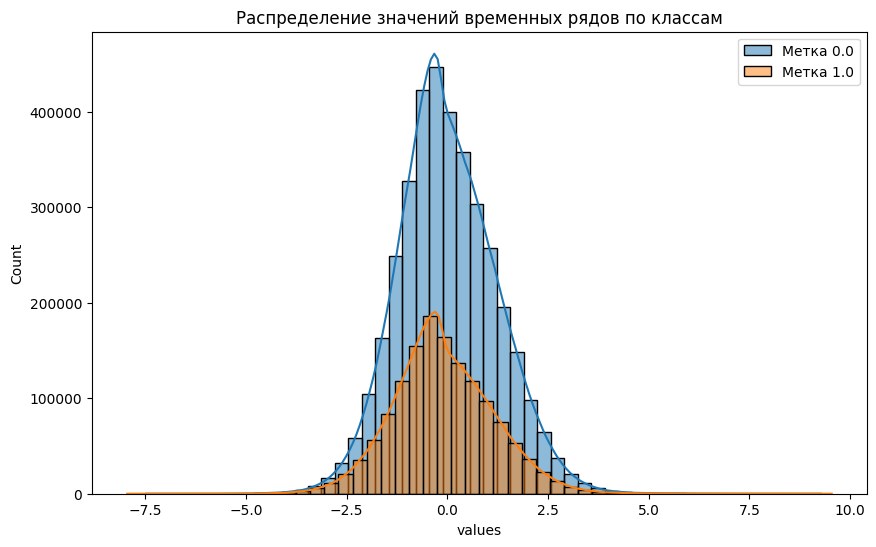

In [21]:
# Гистограммы распределения значений для каждого класса меток
plt.figure(figsize=(10, 6))
for label in df['label'].unique():
    subset = df[df['label'] == label]
    sns.histplot(subset['values'], kde=True, label=f'Метка {label}', bins=50)

plt.title('Распределение значений временных рядов по классам')
plt.legend()
plt.show()

In [22]:
# Статистический анализ
mean_values_by_label = df.groupby('label')['values'].mean()
median_values_by_label = df.groupby('label')['values'].median()
std_values_by_label = df.groupby('label')['values'].std()

print("Средние значения по классам меток:\n", mean_values_by_label)
print("Медианные значения по классам меток:\n", median_values_by_label)
print("Стандартное отклонение по классам меток:\n", std_values_by_label)

Средние значения по классам меток:
 label
0.0     0.00055
1.0   -0.110514
Name: values, dtype: object
Медианные значения по классам меток:
 label
0.0   -0.09
1.0    -0.2
Name: values, dtype: object
Стандартное отклонение по классам меток:
 label
0.0    1.218057
1.0    1.238861
Name: values, dtype: float64


Оба распределения значений по меткам являются нормальными, с небольшими отклонениями.


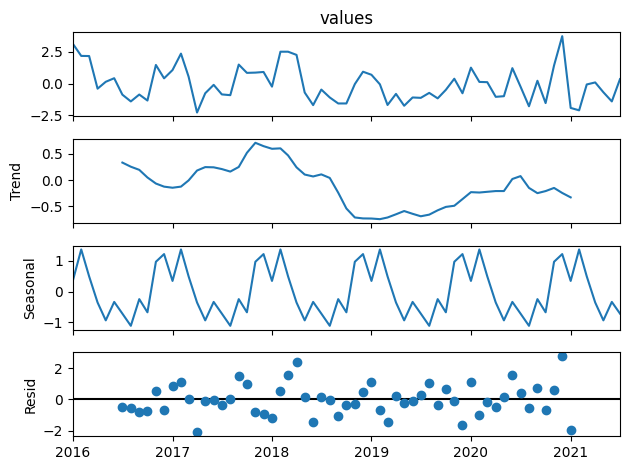

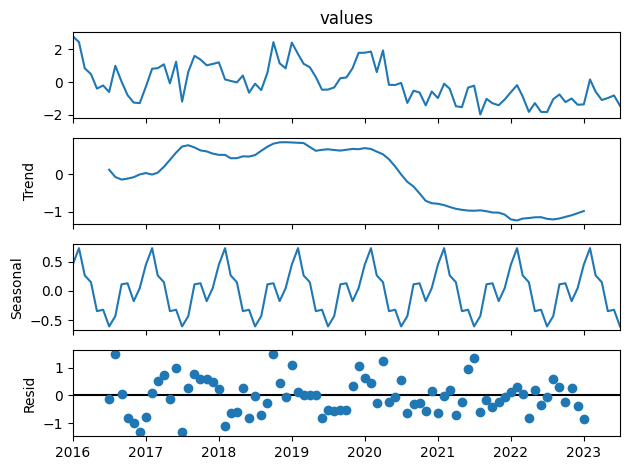

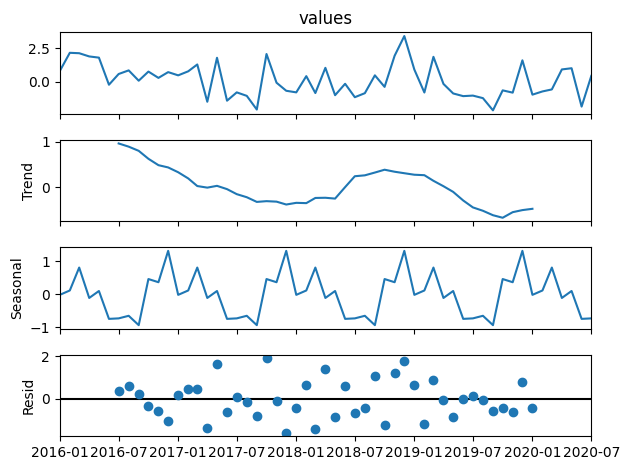

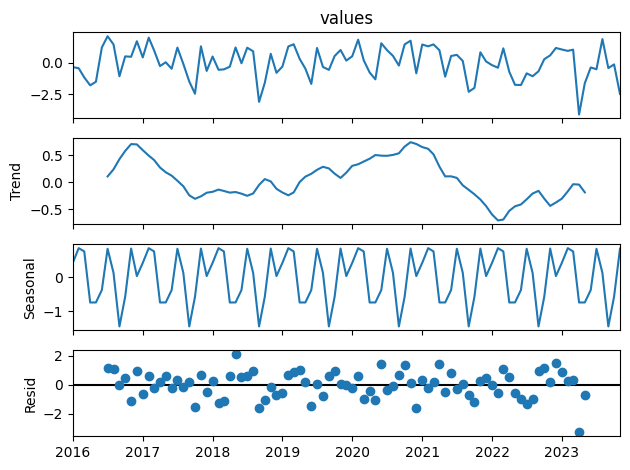

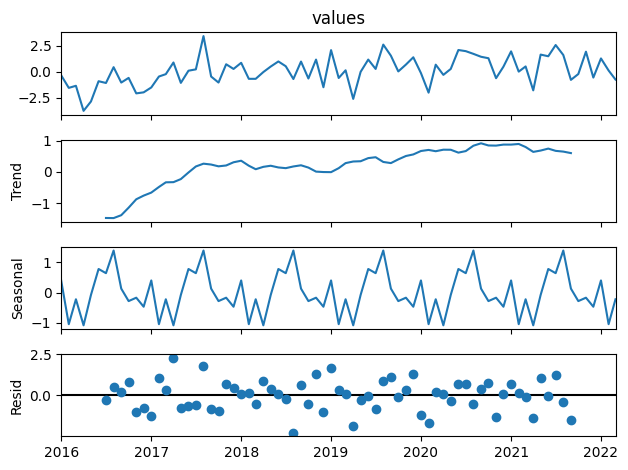

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция временных рядов на тренд и сезонную составляющую для одного ID
for i in range(5):
  example_id = df['id'].sample(1).iloc[0]
  example_series = df[df['id'] == example_id].set_index('dates')['values']
  decomposition = seasonal_decompose(example_series, model='additive', period=12)
  decomposition.plot()
  plt.show()

* Графики показывают различное поведение тренда: в некоторых временных рядах тренд устойчив, в других колеблется.

* Все три графика демонстрируют ярко выраженную сезонную составляющую, указывая на повторяющиеся закономерности. В первом ряду амплитуда сезонных колебаний высокая.

* Остаточные значения в целом выглядят случайными, что указывает на успешное выделение тренда и сезонности. Наличие дисперсии в остатках может быть связано с аномалиями или нерегулярными событиями, не моделируемыми с помощью сезонных и трендовых компонент.

In [24]:
# Преобразование столбца 'values' в тип float и проверка на ошибки
df['values'] = pd.to_numeric(df['values'], errors='coerce')

In [25]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150830 entries, 0 to 5150829
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   id      5150830 non-null  int64         
 1   dates   5150830 non-null  datetime64[ns]
 2   values  5150830 non-null  float64       
 3   label   5150830 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 157.2 MB


In [26]:
df

,id,dates,values,label
0,19114,2016-01-01,-1.86000,0.0
1,19114,2016-02-01,0.79000,0.0
2,19114,2016-03-01,1.40000,0.0
3,19114,2016-04-01,0.15000,0.0
4,19114,2016-05-01,0.00000,0.0
...,...,...,...,...
5150825,98870,2019-11-01,1.40335,1.0
5150826,98870,2019-12-01,0.26335,1.0
5150827,98870,2020-01-01,-1.73665,1.0
5150828,98870,2020-02-01,-0.38665,1.0


# Feature Extraction

In [ ]:
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Расширенное извлечение признаков
fc_parameters = ComprehensiveFCParameters()

extracted_features = extract_features(
    df,
    column_id='id',
    column_sort='dates',
    column_value='values',
    default_fc_parameters=fc_parameters,
    n_jobs=4  
)

# Добавление меток классов к извлеченным признакам
features = extracted_features.copy()

In [131]:
features['label'] = df.drop_duplicates(subset='id').set_index('id')['label']

In [28]:
# Проверка на пропущенные значения
sorted(features.isna().sum(), reverse=True)[:50]

[79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912,
 79912]

In [29]:
# Заполнение пропущенных значений
from tsfresh.utilities.dataframe_functions import impute
features = impute(features)

c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['values__fft_coefficient__attr_"real"__coeff_49'
 'values__fft_coefficient__attr_"real"__coeff_50'
 'values__fft_coefficient__attr_"real"__coeff_51'
 'values__fft_coefficient__attr_"real"__coeff_52'
 'values__fft_coefficient__attr_"real"__coeff_53'
 'values__fft_coefficient__attr_"real"__coeff_54'
 'values__fft_coefficient__attr_"real"__coeff_55'
 'values__fft_coefficient__attr_"real"__coeff_56'
 'values__fft_coefficient__attr_"real"__coeff_57'
 'values__fft_coefficient__attr_"real"__coeff_58'
 'values__fft_coefficient__attr_"real"__coeff_59'
 'values__fft_coefficient__attr_"real"__coeff_60'
 'values__fft_coefficient__attr_"real"__coeff_61'
 'values__fft_coefficient__attr_"real"__coeff_62'
 'values__fft_coefficient__attr_"real"__coeff_63'
 'values__fft_coefficient__attr_"real"__coeff_64'
 'values__fft_coefficient__attr_"real"__coeff_65'

In [30]:
sorted(features.isna().sum(), reverse=True)[:50]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [31]:
# Выбор релевантных признаков с помощью встроенных методов
from tsfresh import select_features

relevant_features = set()

X_train_filtered = select_features(features.drop('label',axis = 1), features['label'])
relevant_features = relevant_features.union(set(X_train_filtered.columns))

print(f'Количество релевантных признаков: {len(relevant_features)}')

Количество релевантных признаков: 461


Слишком много признаков осталось, лучше воспользоваться встроенной проверков xgboost

In [32]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочную и тестовую выборки
X = features.drop(columns=['label'])
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [38]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Функция для оценки качества моделей
def eval_model(model, X_test, y_test):

    roc_auc_scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=3)
    bce_scores = cross_val_score(model, X_test, y_test, scoring='neg_log_loss', cv=3)

    # Средние значения ROC-AUC и BCE (положительное значение BCE)
    print(f'Среднее ROC-AUC: {np.mean(roc_auc_scores):.4f}')
    print(f'Среднее BCE: {abs(np.mean(bce_scores)):.4f}')

In [39]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания и оценка качества модели
eval_model(model, X_test, y_test)

Среднее ROC-AUC: 0.9151
Среднее BCE: 0.3681


In [40]:
# Важность признаков
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Признак': X_train.columns, 'Важность': importances}).sort_values('Важность', ascending=False) 
columns_save = feature_imp_df.head(10)['Признак'].tolist()
columns_save

['values__sum_values',
 'values__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"',
 'values__last_location_of_minimum',
 'values__mean',
 'values__approximate_entropy__m_2__r_0.9',
 'values__fft_aggregated__aggtype_"kurtosis"',
 'values__variance_larger_than_standard_deviation',
 'values__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
 'values__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"',
 'values__fft_coefficient__attr_"real"__coeff_1']

In [41]:
X_train = X_train[columns_save]
X_test = X_test[columns_save]

In [42]:
X_train

,values__sum_values,"values__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",values__last_location_of_minimum,values__mean,values__approximate_entropy__m_2__r_0.9,"values__fft_aggregated__aggtype_""kurtosis""",values__variance_larger_than_standard_deviation,"values__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","values__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","values__fft_coefficient__attr_""real""__coeff_1"
48271,1.610000,-0.046100,0.450000,0.040250,0.282575,17.965759,0.0,-0.757000,-0.871000,7.720839
65604,-4.817203,-0.643374,0.962264,-0.090891,0.249543,9.672998,1.0,-0.632750,-0.700934,-8.822622
78600,0.170000,0.047571,0.645161,0.002742,0.323519,24.745389,1.0,-0.632500,-0.483214,-0.588903
38676,-10.028783,-0.241202,0.151899,-0.126947,0.410255,8.333820,1.0,-1.356754,-0.482212,11.876496
13818,-1.720000,-0.073848,0.267857,-0.030714,0.627219,50.761943,1.0,-2.085714,0.080000,2.966635
...,...,...,...,...,...,...,...,...,...,...
72116,-2.070000,0.325900,0.295455,-0.047045,0.702962,31.098336,1.0,-3.060000,0.344000,1.889889
32382,-0.640000,-0.134983,0.666667,-0.007901,0.606732,14.269674,1.0,-1.107778,-0.181667,3.758027
8652,0.960000,-0.287643,0.957143,0.013714,0.589861,15.197549,1.0,-0.020000,-0.503214,14.089092
11598,1.920000,-0.326429,0.745455,0.034909,0.669280,13.995823,1.0,-0.610476,-0.289429,-13.231613


In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания и оценка качества модели
eval_model(model, X_test, y_test)

Среднее ROC-AUC: 0.8766
Среднее BCE: 0.3966


Качество немного снизилось

# Обучение и подбор гиперпараметров

In [44]:
import numpy as np
import optuna
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Определение функции для оптимизации
def objective(trial):

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log = True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0, log = True),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 5, 10]),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    
    # Кросс-валидация с использованием StratifiedKFold для устойчивости к дисбалансу классов
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    bce_scores = []

    # Стратегия для расчета Binary Cross-Entropy Loss
    for train_index, val_index in skf.split(X_train, y_train):
        # Используем .iloc для корректного доступа к данным по индексам
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_val)
        bce = log_loss(y_val, y_pred_proba)
        bce_scores.append(bce)
    
    # Оптимизируем Binary Cross-Entropy Loss
    return np.mean(bce_scores)

# Создание исследования (study) и запуск оптимизации
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=300, n_jobs=-1, show_progress_bar=True)

[I 2024-10-23 17:55:37,220] A new study created in memory with name: no-name-4d128ce6-e639-4072-a12a-69167ece11af


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-10-23 17:56:07,335] Trial 1 finished with value: 0.6452593649783466 and parameters: {'booster': 'gblinear', 'n_estimators': 800, 'max_depth': 14, 'learning_rate': 0.04004838648942361, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'gamma': 0.30000000000000004, 'reg_alpha': 0.48539988342602886, 'reg_lambda': 0.20291806485464828, 'scale_pos_weight': 5}. Best is trial 1 with value: 0.6452593649783466.
[I 2024-10-23 17:56:10,145] Trial 0 finished with value: 0.4544124540229258 and parameters: {'booster': 'gblinear', 'n_estimators': 850, 'max_depth': 12, 'learning_rate': 0.026909682616221543, 'subsample': 0.4, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 2, 'gamma': 0.0, 'reg_alpha': 0.38279183639741615, 'reg_lambda': 0.024756460901467634, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.4544124540229258.
[I 2024-10-23 17:56:33,208] Trial 5 finished with value: 0.6169658233062908 and parameters: {'booster': 'gblinear', 'n_estimat

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.013653682811418651, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [129]:
X = X[columns_save]

In [130]:
# Обучение модели с лучшими параметрами
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss', random_state=42)
best_model.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.013653682811418651, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [134]:
best_model.save_model('xgboost_model.json')

In [131]:
X_test.columns

Index(['values__sum_values',
       'values__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"',
       'values__last_location_of_minimum', 'values__mean',
       'values__approximate_entropy__m_2__r_0.9',
       'values__fft_aggregated__aggtype_"kurtosis"',
       'values__variance_larger_than_standard_deviation',
       'values__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
       'values__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"',
       'values__fft_coefficient__attr_"real"__coeff_1'],
      dtype='object')

In [128]:
eval_model(best_model, X_test, y_test)

Среднее ROC-AUC: 0.8894
Среднее BCE: 0.3598


In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Определение модели
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
        self.relu = nn.ReLU()
        self.sigmoid = nn.Softmax()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  
        return x

# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Функция для оценки модели
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs) 
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.squeeze().numpy())
    
    # ROC-AUC
    auc = roc_auc_score(y_true, y_pred)
    print(f'ROC-AUC: {auc:.4f}')
    return auc

# Функция для предсказания на новых данных
def predict(model, X_new):
    model.eval() 
    with torch.no_grad():
        X_new_tensor = torch.tensor(X_new.values, dtype=torch.float32)  
        outputs = model(X_new_tensor) 
        probabilities = outputs.squeeze().numpy()  

    return probabilities

# Создание PyTorch DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Инициализация модели, функции потерь и оптимизатора
input_size = X_train.shape[1]  
model = FullyConnectedNN(input_size)

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, train_loader, criterion, optimizer, num_epochs=75)

# Оценка модели
evaluate_model(model, test_loader)

Epoch [1/75], Loss: 0.3900
Epoch [2/75], Loss: 0.3770
Epoch [3/75], Loss: 0.3734
Epoch [4/75], Loss: 0.3707
Epoch [5/75], Loss: 0.3692
Epoch [6/75], Loss: 0.3667
Epoch [7/75], Loss: 0.3650
Epoch [8/75], Loss: 0.3637
Epoch [9/75], Loss: 0.3628
Epoch [10/75], Loss: 0.3614
Epoch [11/75], Loss: 0.3605
Epoch [12/75], Loss: 0.3601
Epoch [13/75], Loss: 0.3594
Epoch [14/75], Loss: 0.3588
Epoch [15/75], Loss: 0.3581
Epoch [16/75], Loss: 0.3578
Epoch [17/75], Loss: 0.3574
Epoch [18/75], Loss: 0.3567
Epoch [19/75], Loss: 0.3563
Epoch [20/75], Loss: 0.3564
Epoch [21/75], Loss: 0.3558
Epoch [22/75], Loss: 0.3556
Epoch [23/75], Loss: 0.3548
Epoch [24/75], Loss: 0.3549
Epoch [25/75], Loss: 0.3544
Epoch [26/75], Loss: 0.3540
Epoch [27/75], Loss: 0.3540
Epoch [28/75], Loss: 0.3535
Epoch [29/75], Loss: 0.3537
Epoch [30/75], Loss: 0.3531
Epoch [31/75], Loss: 0.3525
Epoch [32/75], Loss: 0.3524
Epoch [33/75], Loss: 0.3523
Epoch [34/75], Loss: 0.3519
Epoch [35/75], Loss: 0.3520
Epoch [36/75], Loss: 0.3514
E

np.float64(0.8921995053809207)

Так как и ROC-AUC (больше) и функция потерь у MLP (меньше) лучше, оставляю её

In [126]:
# Обучение на всей выборке
X = X[columns_save]

# Создание PyTorch DataLoader
train_dataset = CustomDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Инициализация модели, функции потерь и оптимизатора
input_size = X.shape[1]  
model = FullyConnectedNN(input_size)

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, train_loader, criterion, optimizer, num_epochs=75)

Epoch [1/75], Loss: 0.3895
Epoch [2/75], Loss: 0.3765
Epoch [3/75], Loss: 0.3729
Epoch [4/75], Loss: 0.3699
Epoch [5/75], Loss: 0.3673
Epoch [6/75], Loss: 0.3646
Epoch [7/75], Loss: 0.3627
Epoch [8/75], Loss: 0.3613
Epoch [9/75], Loss: 0.3601
Epoch [10/75], Loss: 0.3593
Epoch [11/75], Loss: 0.3587
Epoch [12/75], Loss: 0.3580
Epoch [13/75], Loss: 0.3578
Epoch [14/75], Loss: 0.3572
Epoch [15/75], Loss: 0.3571
Epoch [16/75], Loss: 0.3564
Epoch [17/75], Loss: 0.3562
Epoch [18/75], Loss: 0.3557
Epoch [19/75], Loss: 0.3553
Epoch [20/75], Loss: 0.3552
Epoch [21/75], Loss: 0.3550
Epoch [22/75], Loss: 0.3541
Epoch [23/75], Loss: 0.3541
Epoch [24/75], Loss: 0.3538
Epoch [25/75], Loss: 0.3535
Epoch [26/75], Loss: 0.3530
Epoch [27/75], Loss: 0.3529
Epoch [28/75], Loss: 0.3529
Epoch [29/75], Loss: 0.3523
Epoch [30/75], Loss: 0.3527
Epoch [31/75], Loss: 0.3521
Epoch [32/75], Loss: 0.3517
Epoch [33/75], Loss: 0.3510
Epoch [34/75], Loss: 0.3514
Epoch [35/75], Loss: 0.3511
Epoch [36/75], Loss: 0.3511
E

In [127]:
torch.save(model.state_dict(), 'trained_model.pth')